# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 26.09.2021

Мягкий дедлайн: 23:59MSK 11.10.2021

Жесткий дедлайн: 23:59MSK 14.10.2021

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

plt.subplots(figsize=(20,5))
sns.set(font_scale=1.5)
sns.set(style="darkgrid")

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 20, 8

from sklearn.model_selection import train_test_split

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
train = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [5]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
train.drop('dropoff_datetime', axis=1, inplace=True)
train.pickup_datetime = pd.to_datetime(train.pickup_datetime)
train.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

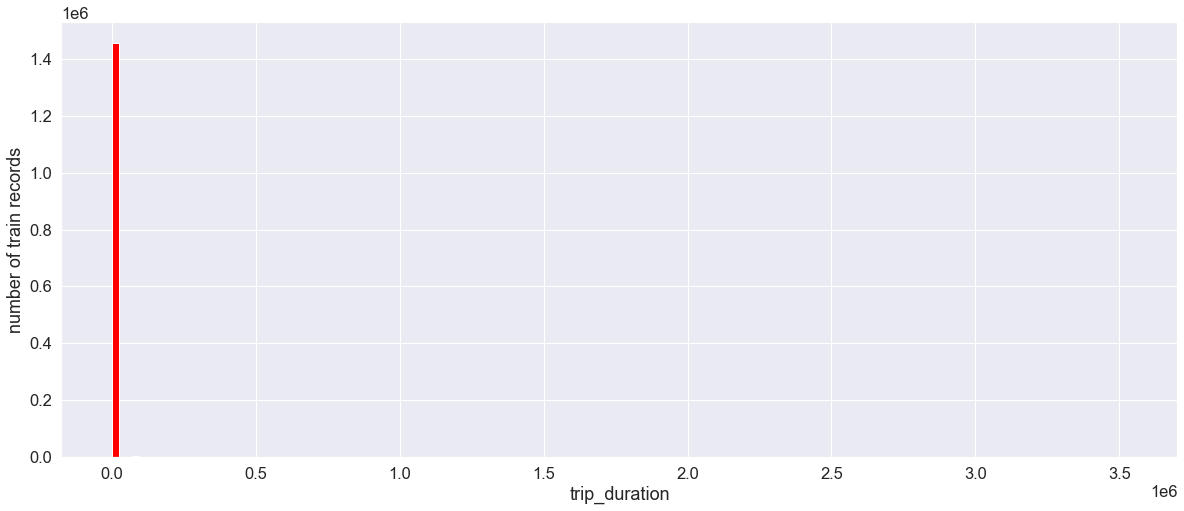

In [7]:
sns.set(font_scale=1.5)
plt.hist(train['trip_duration'].values, bins=150, color='red')
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

Так как график получился неинформативным (из-за слишком большого разброса возможных значений длины поездки и из-за того, что основная часть поездок является не очень продолжительными), построю дополнительно график с использованием логарифмической шкалы

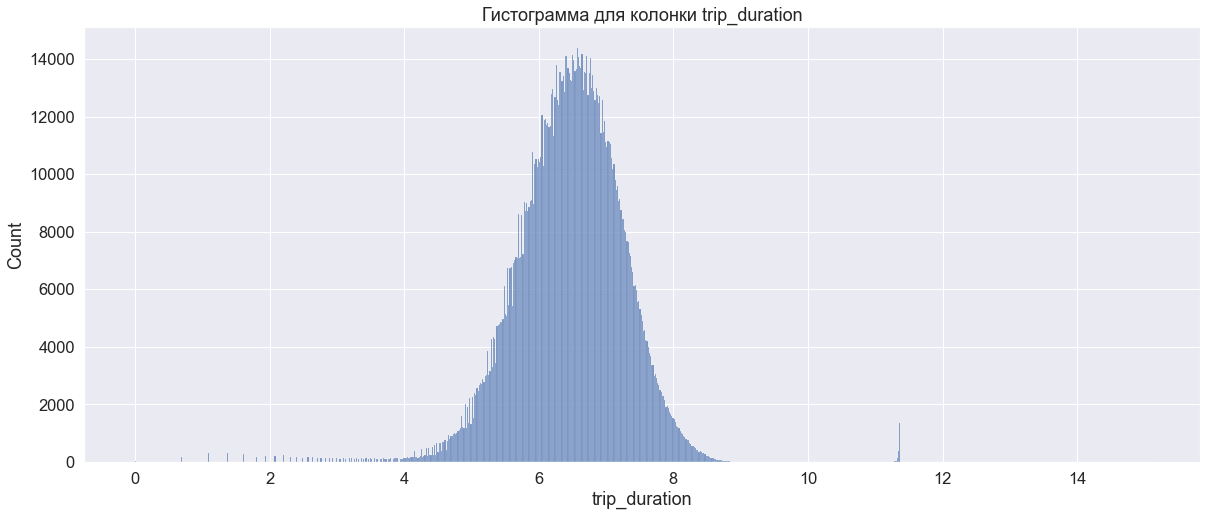

In [8]:
sns.histplot(np.log(train.trip_duration))
plt.title('Гистограмма для колонки trip_duration')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

По графику видно, что целевая переменная распределена почти нормально, но имеется немалое количестов поездок, которые были сильно корече средней продолжительности, а так же присутствуют долгие поездки.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ:** Как мы заметили чуть ниже по гистограмме, наши данные имеют выбросы - а RMSE не устойчива к ним. Ошибка сразу становится огромной. Мы берем логарифмы, и наша целевая переменная вполне под такие преобразования подходит: самое маленькое значение которое она может принимать - это ноль, т.е поездка тут же завершилась, в формуле для таких случаев прибавляется единица.

RMSLE, имеет несколько преимуществ по сравнению с RMSE:

* RMSE гораздо более чувствительно к выбросам, чем RMSLE

* RMSLE по сути оценивает относительную оценку, так как можно представить:
    
    $\large \log(y_i + 1) - \log(a(x_i) + 1) = \log(\frac{y_i + 1}{a(x_i + 1)})$

* RMSE - симметричная функция, потому недопрогноз и перепрогноз штрафуются одинаково, в то же время RMSLE штрафует за недопрогноз сильнее, чем за перепрогноз. Очевидно, что в данной задаче недопрогноз гораздо хуже перепрогноза, потому что недопрогноз череват опазданиями для клиентов, наверное, это и есть основная причина выбора авторами данного функционала ошибки для этого соревнования.


На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Ответ**:  Натуральный логарифм смешает минимум функции, но так как мы добавляем + 1, тогда минимум будет в той же точке. Так как мы взяли квадрат, необходимо взять корень, а взятие корня это монотонное преобразование, а такое преобразование не изменяет положение оптимума.

$a(x_i) = \exp(\hat{a}(x_i)) - 1$

$\hat{a}(x_i) = \log(a(x_i) + 1)$

$MSE(X,\hat{y},\hat{a}) = MSE(X, \log{(y_i + 1)}, \log(a(x_i) + 1)) = \frac{1}{\ell}\sum_{i=1}^{\ell}(\log{(y_i + 1)} - \log{(a(x_i) + 1)})^2 = (RMSLE(X,y,a))^2$

А это понятно почему эквивалентно - оба числа были положительны (RMSLE не в квадрате в частности). И уменьшение RMSLE эквивалентно уменьшению MSE для данных моделей.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [9]:
train['log_trip_duration'] = np.log1p(train.trip_duration)
train = train.drop('trip_duration', axis=1)

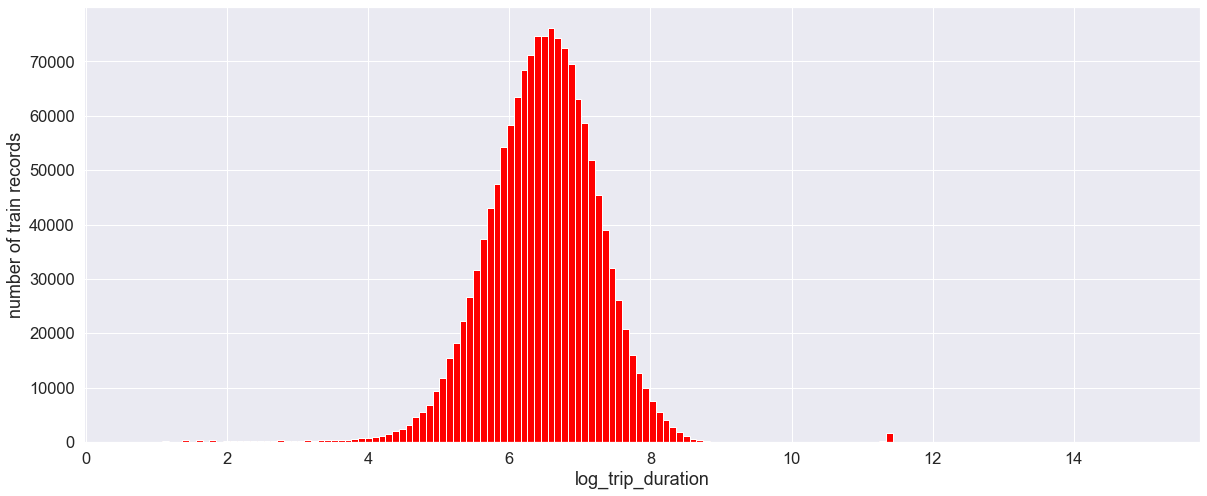

In [10]:
plt.hist(train['log_trip_duration'].values, bins=150, color='red')
plt.xlabel('log_trip_duration')
plt.ylabel('number of train records')
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [11]:
from sklearn import linear_model, metrics
y = train.log_trip_duration.values
metrics.mean_squared_error(np.mean(y) * np.ones(y.shape), y, squared=False)

0.7957592365411509

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

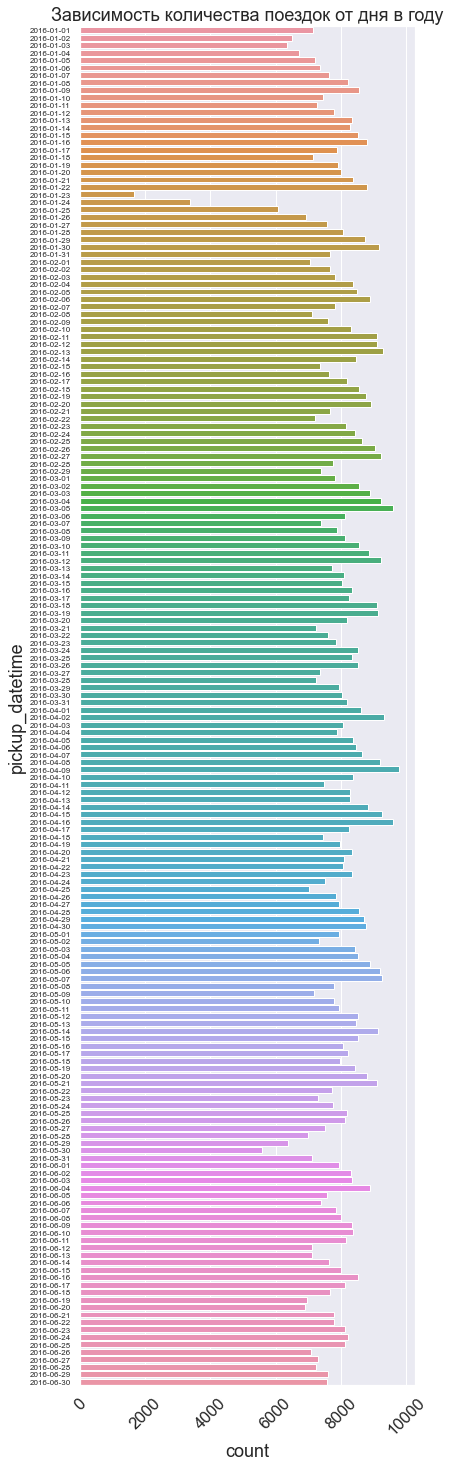

In [12]:
fig = plt.figure(figsize=(6, 25))
ax = fig.add_subplot()
sns.countplot(y=train.pickup_datetime.sort_values().dt.date)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='x', labelrotation=45)
plt.title('Зависимость количества поездок от дня в году')
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

График немного похож на что-то периодическое, видимо пики, которые всё время повторяются это выходные дни, когда люди ездят на такси чаще всего, но выбиваются из общих закономерностей два периода: 1) 23 - 25 января 2016. В эти дни в Нью-Йорке произошёл сильнейший снегопад и 23 числа власти запретили автомобильное движение по улицам города.

2) 29 - 30 мая 2016 (есть небольшой провал, на всякий случай узнаю, что там было). В этот день в аэропорту Нью-Йорка произошёл технический сбой компьютеров из-за чего образовались очереди и массовая задержка рейсов. (я немного не понимаю, почему это повлияло на количество вызовов такси, но тем не менее, кажется, что это так)

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):



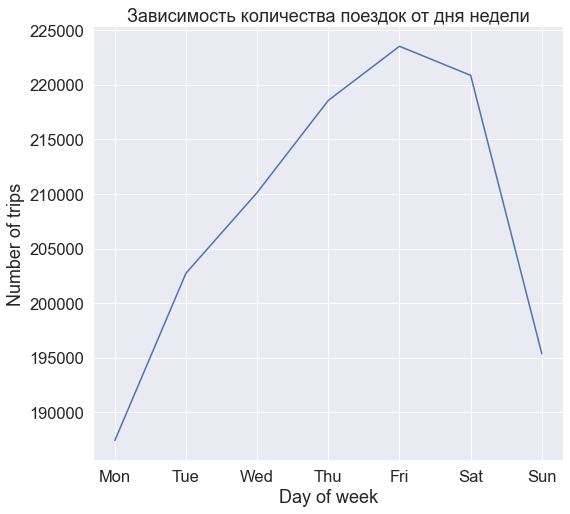

In [13]:
group_by_weekday = train.pickup_datetime.dt.day_of_week.value_counts()

relplot_weekday = sns.relplot(data=group_by_weekday, kind='line', sizes=(10,100));
relplot_weekday.set(xlabel="Day of week", ylabel = "Number of trips")
relplot_weekday.fig.set_size_inches(10,8)

plt.title('Зависимость количества поездок от дня недели')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

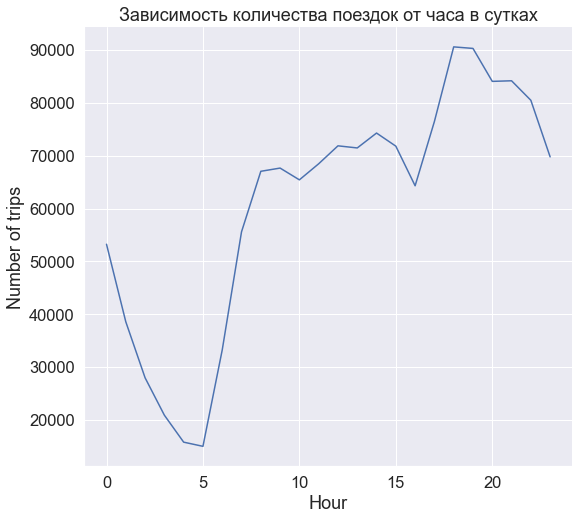

In [14]:
group_by_hour = train.pickup_datetime.dt.hour.value_counts()

relplot_hour = sns.relplot(data=group_by_hour, kind='line', sizes=(10,100));
relplot_hour.set(xlabel="Hour", ylabel="Number of trips")
relplot_hour.fig.set_size_inches(10,8)

plt.title('Зависимость количества поездок от часа в сутках')
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [15]:
group_by_month_hour = pd.DataFrame({'month': train.pickup_datetime.dt.month_name(), 
                                    'hour': train.pickup_datetime.dt.hour}).value_counts()

group_by_month_hour = group_by_month_hour.to_frame().reset_index()
group_by_month_hour = group_by_month_hour.rename(columns={0 :'count_of_trip'})

group_by_month_hour.head()

,month,hour,count_of_trip
0,March,18,16404
1,March,19,16246
2,April,19,15714
3,February,18,15454
4,April,18,15315


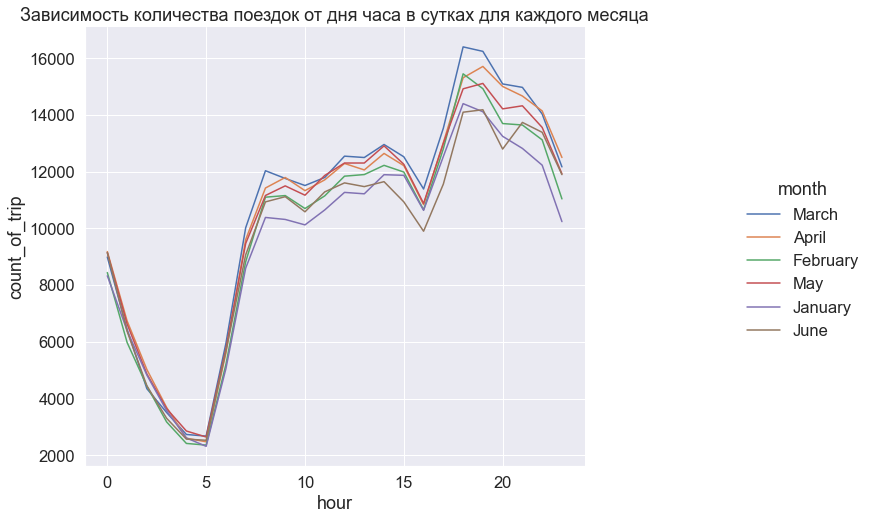

In [16]:
relplot_month_hour = sns.relplot(data=group_by_month_hour, x='hour', y='count_of_trip', kind='line', hue='month');
relplot_month_hour.fig.set_size_inches(15, 8)

plt.title('Зависимость количества поездок от дня часа в сутках для каждого месяца')
plt.show()
# new_labels = ['January', 'February', 'March', 'April', 'May', 'June']
# for t, l in zip(relplot_month_hour._legend.texts, new_labels): t.set_text(l)

**Используем второй вариант**

Позволяет записать действия выше в более простой форме.

In [17]:
train['hour'] = train.pickup_datetime.dt.hour
train['month'] = train.pickup_datetime.dt.month
train['day_of_week'] = train.pickup_datetime.dt.day_of_week

In [18]:
group_by_wday_hour = pd.DataFrame({'count_of_trip': train.groupby(by=[train.day_of_week, 
                                                                      train.hour]).size()
                                  }).reset_index()

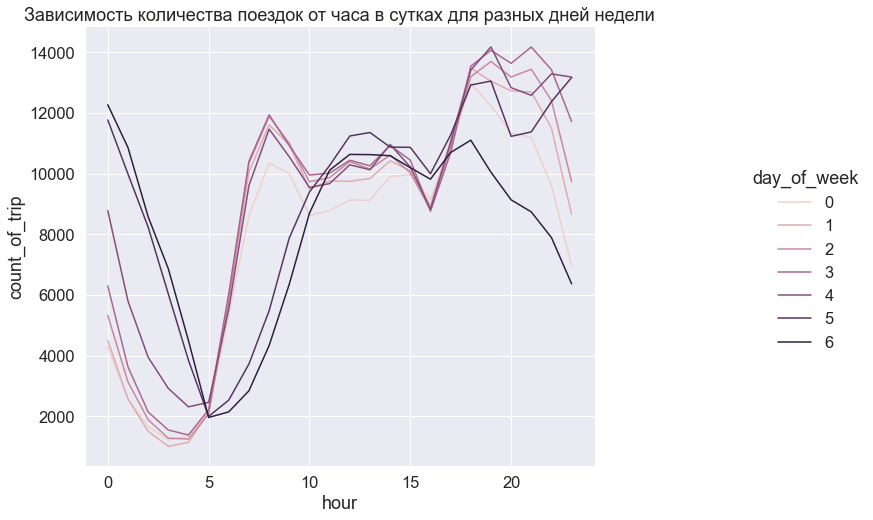

In [19]:
relplot_month_hour = sns.relplot(data=group_by_wday_hour, x='hour', y='count_of_trip', kind='line', hue='day_of_week');
relplot_month_hour.fig.set_size_inches(15, 8)

plt.title('Зависимость количества поездок от часа в сутках для разных дней недели')
plt.show()

Удалю колонки, которые были вспомогательными для построения данных графиков:

In [20]:
train.drop(['hour', 'month', 'day_of_week'], axis=1, inplace=True)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ:**

Два графика выше очень похожи друг на друга, то есть в целом тенданция зависимости количества поездок от часа в сутках очень устойчивая и для разных месяцев и для разных дней недели общая картина выглядит примерно одинаково.

При этом для месяцев распределения количества поездок от часа достаточно похожи друг на друга и от месяца к месяцу всё повторяется. Но для дней недели всё немного иначе,в разные дни мы видим несколько разное число поездок в одно и то же время суток

1. Если посмотреть на график зависимости количества поездок от времени суток по месяцам, то замечаем повторяющийся тренд, причем достаточно четко сохраняющийся. Что вполне ожидаемо, так как нагрузка на транспорт обычно бывает в вечернее время ( по будням), кгда люди едут с работы - по графику это с 17 до 21 часа. Плюс на дорогах пробки, кто-то спешит, торопится или не хочет ехать в забитом общественном транспорте... Также можно заметить, что с приближением к Июню в среднем графики немного спускаются параллельно оси 'count_of_trip'. Можно объяснить это тем, что зимой в Нью-Йорке отвратительная погода, дожди ... поэтому передвигаться на более удобном виде транспорта куда более охотно, чем летом, летом можно и пешком пройтись побольше, прогуляться.

2. Теперь посмотрим на график зависимости количества поездок от времени сутк по дням недели. Сразу можно заметить, что очень выделяются графики пятницы и вскресенья, там количество поездок выше в период с 5 до 11 утра и с 17 до ночи. Ну что сказать, ночью многие возвращаются из баров и всяких тусовок после бурного вечера субботы походу. Похожее поведение у графиков будничных дней с пн по четверг ив субботу. А пятница и воскресенье - крайние либо рабочие, либо выходные дни, что сказывается на отличающемся поведении графиков.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [21]:
y = train.log_trip_duration
X = train.drop(["log_trip_duration"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

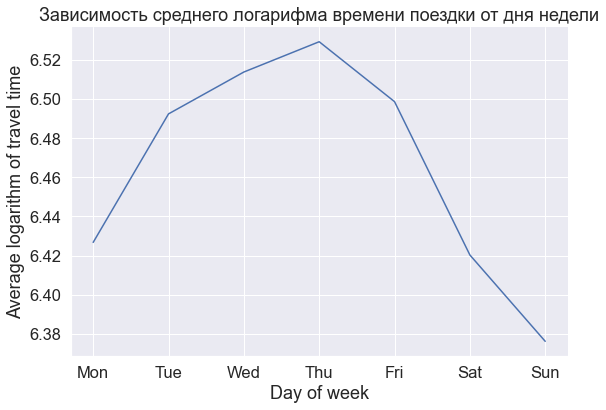

In [22]:
group_by_weekday = y_train.groupby(X_train.pickup_datetime.dt.day_of_week)

relplot_weekday_mean = sns.relplot(data=group_by_weekday.aggregate('mean'), kind="line")
relplot_weekday_mean.fig.set_size_inches(10, 6)

plt.title('Зависимость среднего логарифма времени поездки от дня недели')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of week')
plt.ylabel('Average logarithm of travel time')
plt.show()

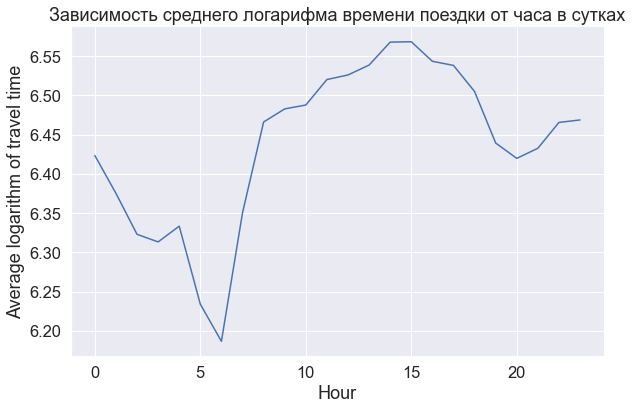

In [23]:
group_by_hour = y_train.groupby(X_train.pickup_datetime.dt.hour)

relplot_hour_mean = sns.relplot(data=group_by_hour.aggregate('mean'), kind="line");
relplot_hour_mean.set(xlabel='Hour', ylabel='Average logarithm of travel time')
relplot_hour_mean.fig.set_size_inches(10, 6)

plt.title('Зависимость среднего логарифма времени поездки от часа в сутках')
plt.show()

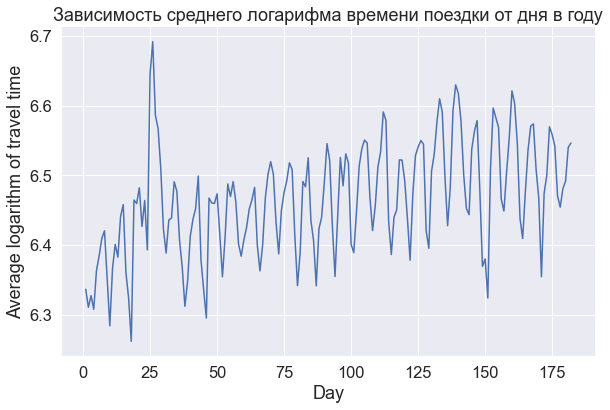

In [24]:
group_by_days = y_train.groupby(X_train.pickup_datetime.dt.day_of_year)

relplot_days_mean = sns.relplot(data=group_by_days.aggregate('mean'), kind="line");
relplot_days_mean.set(xlabel="day_of_year")
relplot_days_mean.fig.set_size_inches(10, 6)

plt.title('Зависимость среднего логарифма времени поездки от дня в году')
plt.xlabel('Day')
plt.ylabel('Average logarithm of travel time')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ:**

Графики зависимости таргета от дня недели и от часа в сутках похожи на аналогичные графики для количества поездок. Это можно объяснить тем, что примерно большая часть поездок имеет длину, которая не имеет сильный разброс, т.е долгих поездок, которые значительно отличаются по времени не так много. следовательно каждая новая поездка в конкретный период дает относительно такой же вклад как по количеству времени, так и просто в единицу, дающая вклад в количесво поездок. \ В аномальные периоды график ведет себя похоже как и выше для количества поездок, тут опять же можно рассуждать аналогично. Тренд заметен - это такие горки на графики, каждый из которых похож на график зависимости таргета от для недели, вот такой тренд и замечаем на общем графике зависимости log_trip_duration от номера дня в году.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [25]:
train['day_of_week'] = train.pickup_datetime.dt.day_of_week
train['month'] = train.pickup_datetime.dt.month
train['hour'] = train.pickup_datetime.dt.hour
train['day_of_year'] = train.pickup_datetime.dt.day_of_year

train['is_snowfall_period'] = 0
train.loc[train.day_of_year.isin([23, 24, 25]), 'is_snowfall_period'] = 1

train['is_airport_broke_period'] = 0
train.loc[train.day_of_year.isin([150, 151]), 'is_airport_broke_period'] = 1

In [26]:
y = train.log_trip_duration
X = train.drop(["log_trip_duration"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ:**

1. День недели - категориальный, мы наблюдали на гафиках тренд, который зависел от дня недели и повторялся каждую неделю, а если он числовой будет, то не совсем понятно, чем больше число - тем важнее признак? - не совсем работает.
2. Месяц - категориальный
3. Час - категориальный, сложно определить зависимость, что если +1 час - то что меняется с таргетом. и после 23 идет 0, зависимость тоже не понятна.
4. Является ли период аномальным - они у нас уже два бинарных признака, соответствующие двум аномальным периодам
5. Номер дня в году скорее вещественный, есть тренд, который повторяется, плюс будем предсказывать для дней, которые в будущем, что логичнее. И после one-hot кодирования будет +365 признаков - что весьма много.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [28]:
categorical_features = ['day_of_week', 'month', 'hour']
numeric_features = ['day_of_year']
other = ['is_snowfall_period', 'is_airport_broke_period']

column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features),
    ('other', 'passthrough', other)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


model = ridge_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print("RMSE = %.4f" % mean_squared_error(y_valid, y_pred, squared=False))

RMSE = 0.7880


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [29]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [30]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [31]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

На карте выделяются 2 точки кроме Манхэттена - это аэропорт имени Джона Кеннеди и аэропорт LaGuardia

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [32]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [33]:
train.loc[:, 'haversine'] = haversine_array(train['pickup_latitude'].values, 
                                            train['pickup_longitude'].values, 
                                            train['dropoff_latitude'].values, 
                                            train['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [34]:
# Количество поездок с нулевым расстоянием
train.query('haversine == 0').shape

(5897, 17)

Так как существуют нулевые значения в колонке расстояния, чтобы избежать бесконечности в колонке log_haversine, запишу в эту колонку логарифм от haversine + 1

In [35]:
train['log_haversine'] = np.log1p(train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

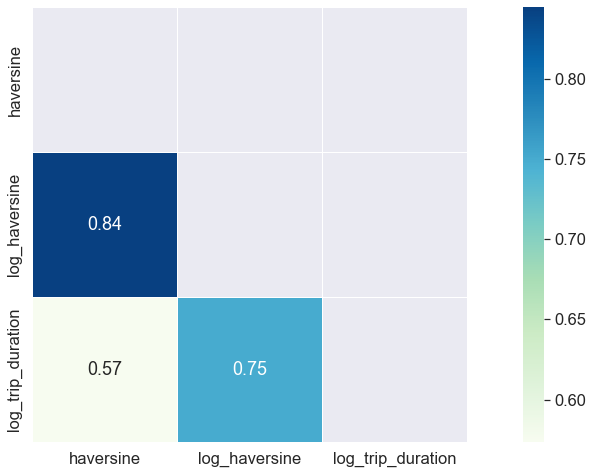

In [36]:
corr = train[['haversine', 'log_haversine', 'log_trip_duration']].corr()

mask = np.triu(corr)
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', square=True, linewidths=.5, cmap='GnBu')
plt.show()

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [37]:
train_speed = train['haversine'] /((np.exp(train['log_trip_duration']) - 1)/3600)

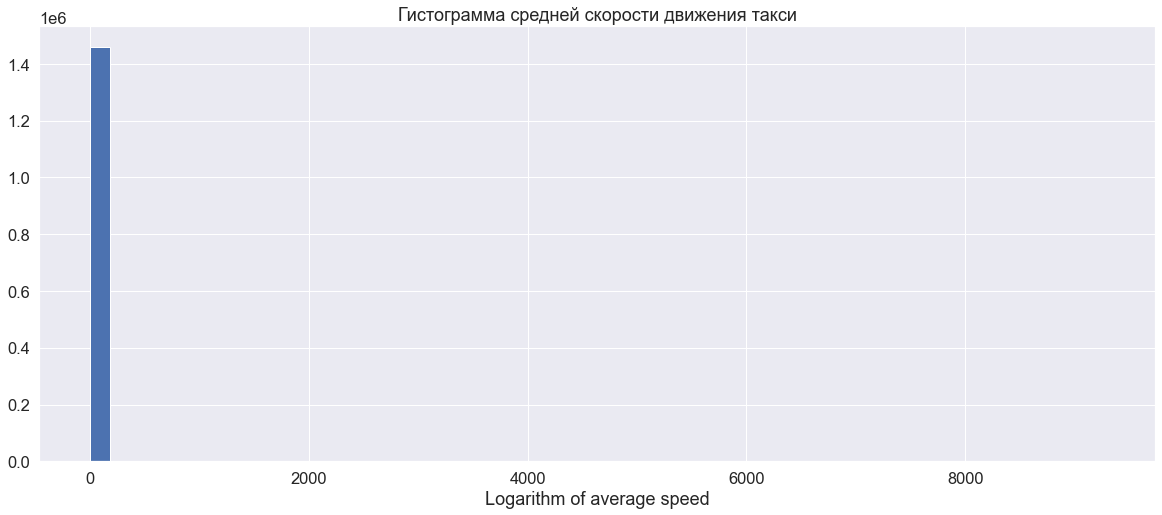

In [38]:
plt.hist(train_speed, bins=50)
plt.title('Гистограмма средней скорости движения такси')
plt.xlabel('Logarithm of average speed')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [39]:
# Посмотрим кол-во объектов со скоростью больше 120 км/ч
train_speed[train_speed > 50]

980          51.093300
991          64.095730
1107       1265.516683
1383         62.036465
1492         78.564914
              ...     
1456538      52.185369
1456545      50.372608
1456841      50.712951
1457984      55.699748
1458290      54.004382
Length: 2965, dtype: float64

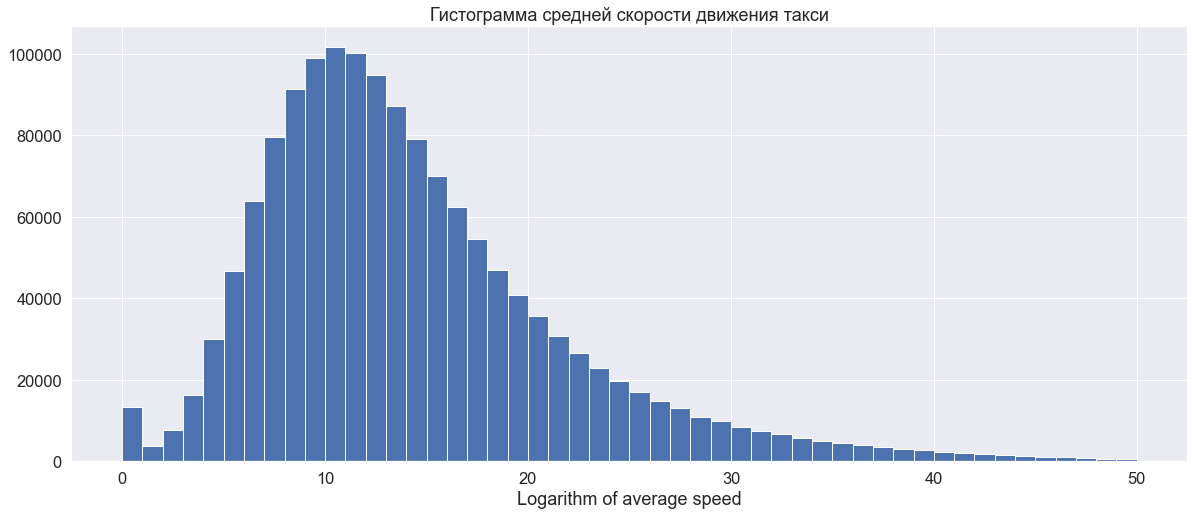

In [40]:
plt.hist(train_speed[train_speed <= 50], bins=50)
plt.title('Гистограмма средней скорости движения такси')
plt.xlabel('Logarithm of average speed')
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

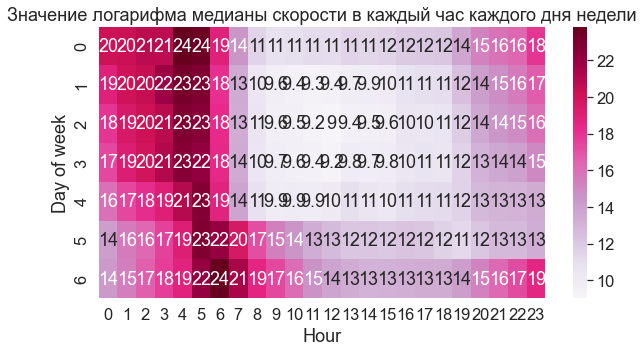

In [41]:
train['speed'] = train_speed

tmp = pd.DataFrame(
    {'median_speed': train.groupby(by=[train.day_of_week, train.hour])['speed'].median()}
).reset_index()

hour_day_of_week = tmp.pivot(index='day_of_week',
                             columns='hour',
                             values='median_speed')

fig = plt.figure(figsize=(10, 5))
sns.heatmap(data=hour_day_of_week, annot=True, cmap="PuRd")
# plt.yticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.xlabel('Hour')
plt.ylabel('Day of week')
plt.title('Значение логарифма медианы скорости в каждый час каждого дня недели')
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [42]:
train.drop('speed', axis=1, inplace=True)

Значение скорости нельзя использовать во время обучания, так как его мы получили для тренировочной выборки с использование целевой переменной, следовательно этот признак мы не сможем получить ни на каком новом объекте.

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Самую низкую скорость движения мы наблюдаем в утренне и вечернее время рабочих дней, то есть с понедельника по пятницу с 8 до 11 (или даже 12) и с 17 до 19. В принципе, такой результат ожидаем для такого города как Нью-Йорк. Этот результат согласуется с нашим реальным жизненым опытом.

В выходные же дни низкую скорость движения мы наблюдаем чуть позже, а именно с 10 до 13.

Самую высокую скорость движения, а как следствие и отсутствие пробок мы наблюдаем в будние дни в 4-5 утра, а в выходные дни в 5-6 утра. Это тоже можно объяснить логически. Просто в будние дни большому числу людей на следующий день вставать на работу, поэтому эта большая часть людей уже спит.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [43]:
# train['is_traffic_jams'] = 0

# train.loc[((train['day_of_week'].isin(list(range(5)))) &
#                 (train['hour'].isin(list(range(8, 13)))
#                  |
#                  train['hour'].isin(list(range(17, 20))))),'is_traffic_jams'] = 1

# train.loc[((train['day_of_week'].isin(list(range(6, 8)))) &
#                 (train['hour'].isin(list(range(10, 14))))),'is_traffic_jams'] = 1

# train.loc[((train['day_of_week'] == 5) &
#                 (train['hour'].isin(list(range(18, 23))))),'is_traffic_jams'] = 1


# train['is_free_roads'] = 0
# train.loc[((train['day_of_week'].isin(list(range(5)))) &
#                 (train['hour'].isin(list(range(4, 6))))),'is_free_roads'] = 1

# train.loc[((train['day_of_week'].isin(list(range(5, 7)))) &
#                 (train['hour'].isin(list(range(5, 7))))),'is_free_roads'] = 1


In [44]:
# train['is_trafic'] = ((train['pickup_datetime'].dt.weekday < 5) \
#                 & ((train['pickup_datetime'].dt.hour > 6) \
#                 & (train['pickup_datetime'].dt.hour < 10)) \
#                 | ((train['pickup_datetime'].dt.hour > 16) \
#                 & (train['pickup_datetime'].dt.hour < 23))).apply(lambda x: 1 if x else 0)

# train['is_free'] = ((train['pickup_datetime'].dt.weekday > 4) \
#             & (train['pickup_datetime'].dt.hour > 3) \
#             & (train['pickup_datetime'].dt.hour < 8) \
#             | (train['pickup_datetime'].dt.weekday < 5) \
#             & (train['pickup_datetime'].dt.hour > 0) \
#             & (train['pickup_datetime'].dt.hour < 5)).apply(lambda x: 1 if x else 0)


In [45]:
train['is_trafic'] = 0
train.loc[(train['day_of_week'] < 5) 
          & (train['hour'] > 7)
          & (train['hour'] < 16),
          'is_trafic'] = 1

train['is_free'] = 0
train.loc[(train['day_of_week'] > 4) 
          & (train['hour'] > 3)
          & (train['hour'] < 8)
          
          | (train['day_of_week'] < 5) 
          & (train['hour'] < 7),
          'is_free'] = 1

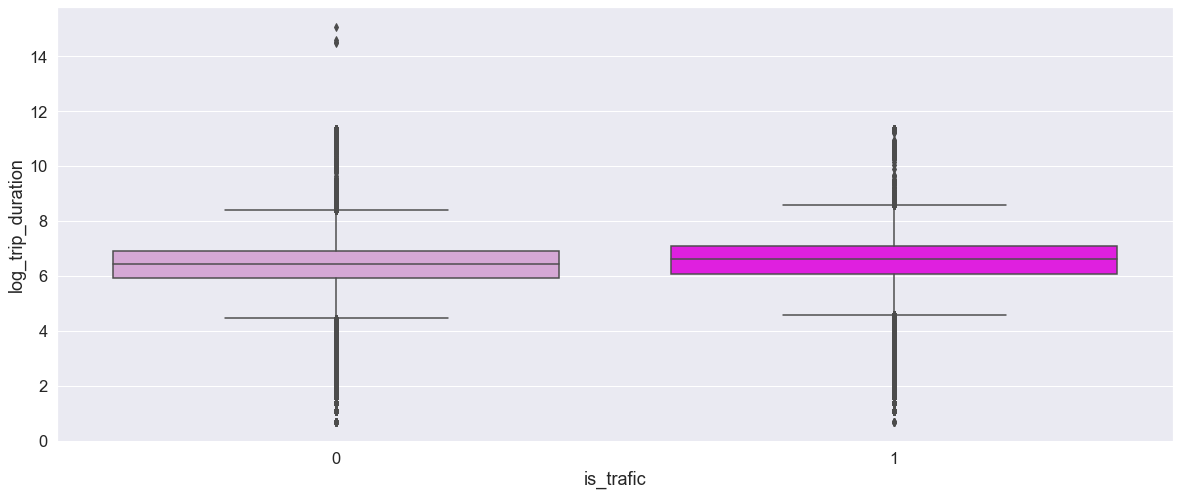

In [46]:
ax = sns.boxplot(x='is_trafic', y="log_trip_duration", data=train, palette = ['plum', 'magenta'])

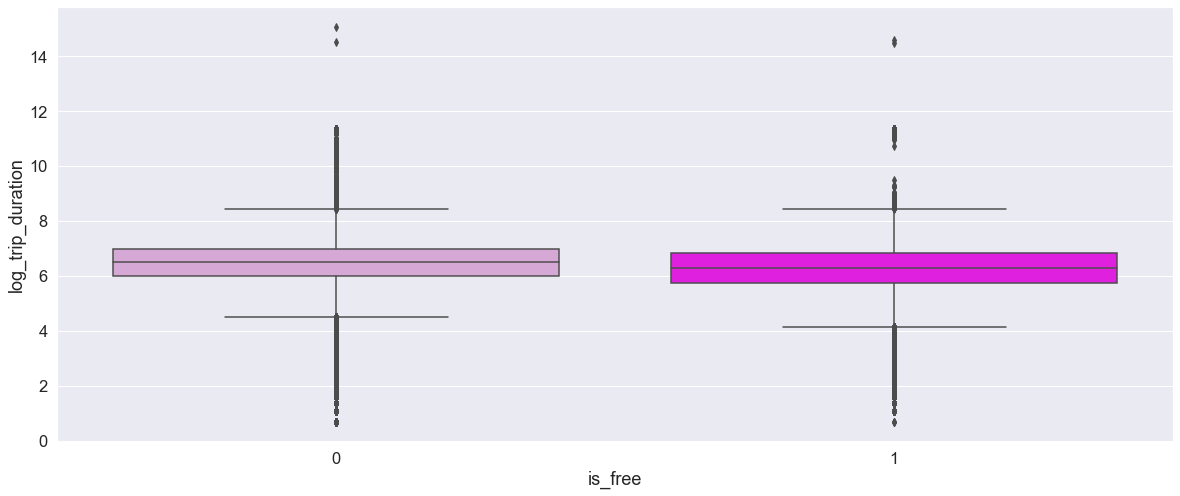

In [47]:
ax = sns.boxplot(x='is_free', y="log_trip_duration", data=train, palette = ['plum', 'magenta'])

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [48]:
train['pickup_lag'] = ((train['pickup_latitude'] <= 40.77600) \
                        & (train['pickup_latitude'] >= 40.76700) \
                        & (train['pickup_longitude'] >= -73.88800) \
                        & (train['pickup_longitude'] <= -73.86300)).apply(lambda x: 1 if x else 0)
train['dropoff_lag'] = ((train['dropoff_latitude'] <= 40.77600) \
                        & (train['dropoff_latitude'] >= 40.76700) \
                        & (train['dropoff_longitude'] >= -73.88800) \
                        & (train['dropoff_longitude'] <= -73.86300)).apply(lambda x: 1 if x else 0)

In [49]:
train['pickup_ken'] = ((train['pickup_latitude'] <= 40.65000) \
                        & (train['pickup_latitude'] >= 40.63800) \
                        & (train['pickup_longitude'] >= -73.79400) \
                        & (train['pickup_longitude'] <= -73.77300)).apply(lambda x: 1 if x else 0)
train['dropoff_ken'] = ((train['dropoff_latitude'] <= 40.65000) \
                        & (train['dropoff_latitude'] >= 40.63800) \
                        & (train['dropoff_longitude'] >= -73.79400) \
                        & (train['dropoff_longitude'] <= -73.77300)).apply(lambda x: 1 if x else 0)


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

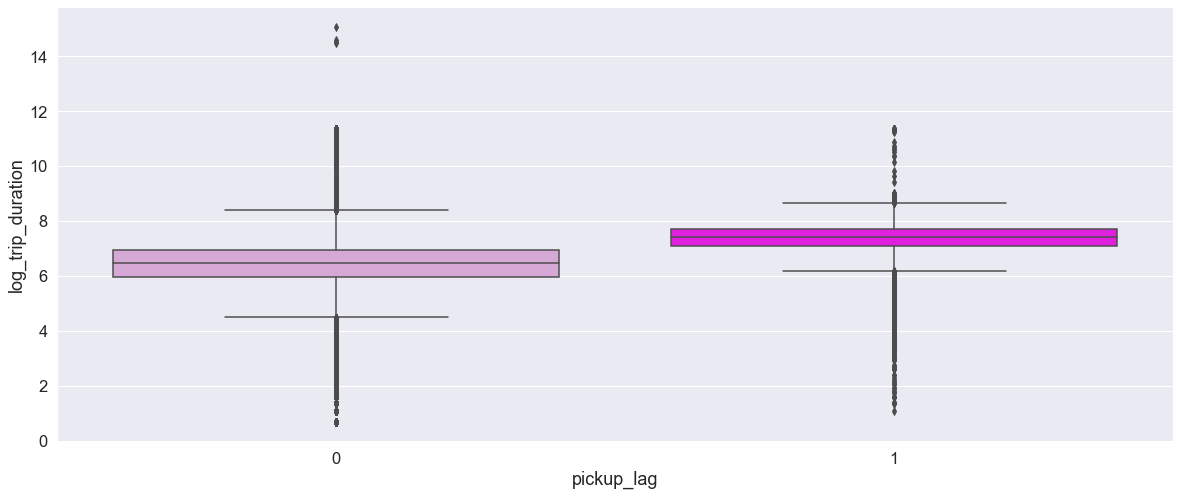

In [50]:
ax = sns.boxplot(x='pickup_lag', y="log_trip_duration", data=train, palette = ['plum', 'magenta'])

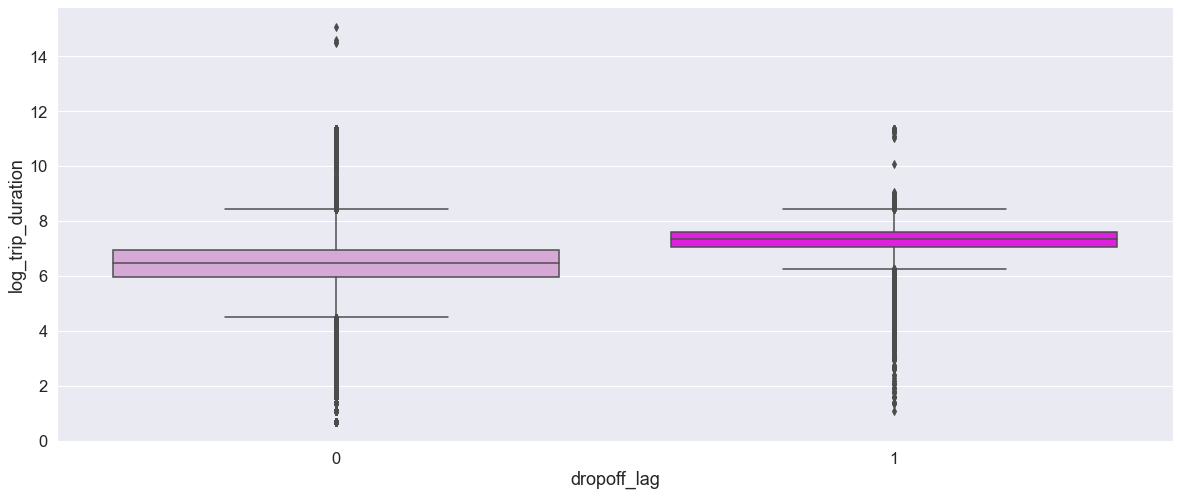

In [51]:
ax = sns.boxplot(x='dropoff_lag', y="log_trip_duration", data=train, palette = ['plum', 'magenta'])

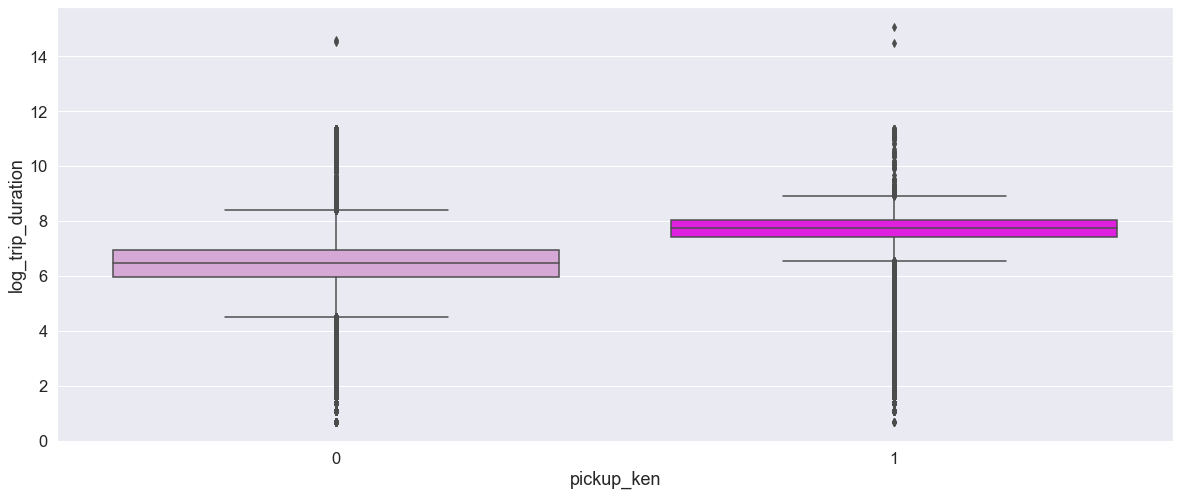

In [52]:
ax = sns.boxplot(x='pickup_ken', y="log_trip_duration", data=train, palette = ['plum', 'magenta'])

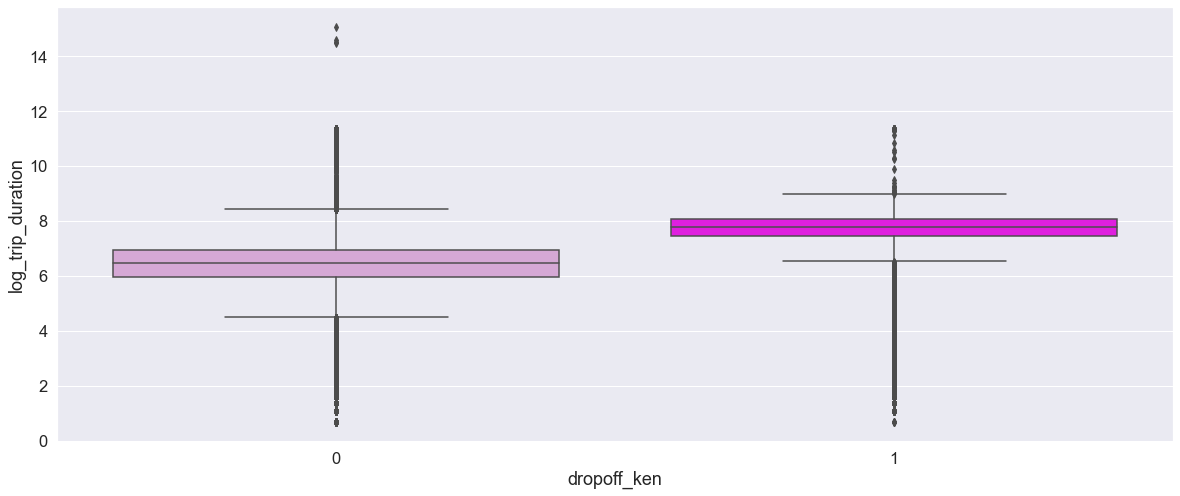

In [53]:
ax = sns.boxplot(x='dropoff_ken', y="log_trip_duration", data=train, palette = ['plum', 'magenta'])

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Судя по графикам признаки получились хорошие.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nrows=4, ncols=3):
        self.nrows = nrows
        self.ncols = ncols
        
    def fit(self, X, y=None):
        X_ = X.values
        self.b, self.l = np.median(X_, axis=0) - X_.std(axis=0)*1
        self.t, self.r = np.median(X_, axis=0) + X_.std(axis=0)*1
        self.row_h = (self.t - self.b) / self.nrows
        self.col_w = (self.r - self.l) / self.ncols
        return self
    
    def transform(self, X):
        X_ = X.values
        c = (X_[:, 1] - self.l) // self.col_w
        r = (X_[:, 0] - self.b) // self.row_h
        n = c + r * self.ncols + 1
        n[(X_[:, 1] < self.l) + (X_[:, 1] > self.r) + \
          (X_[:, 0] < self.b) + (X_[:, 0] > self.t)] = 0
        return n.astype(int)
    
    def fit_transform(self, X ,y=None):
        return self.fit(X).transform(X)

In [55]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration',
       'day_of_week', 'month', 'hour', 'day_of_year', 'is_snowfall_period',
       'is_airport_broke_period', 'haversine', 'log_haversine', 'is_trafic',
       'is_free', 'pickup_lag', 'dropoff_lag', 'pickup_ken', 'dropoff_ken'],
      dtype='object')

In [56]:
t = MapGridTransformer()
grid_pickup = t.fit_transform(train[['pickup_longitude', 'pickup_latitude']])
grid_dropoff = t.fit_transform(train[['dropoff_longitude','dropoff_latitude']])
train['pickup'] = grid_pickup
train['dropoff'] = grid_dropoff

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [57]:
y = train.log_trip_duration
X = train.drop(["log_trip_duration"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
categorical_features = ['day_of_week', 'month', 'hour', 'pickup', 'dropoff']
numeric_features = ['day_of_year', 'log_haversine']
other = ['is_snowfall_period', 'is_airport_broke_period', 'is_trafic',
       'is_free', 'pickup_lag', 'dropoff_lag', 'pickup_ken', 'dropoff_ken']

column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features),
    ('other', 'passthrough', other)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


model = ridge_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print("RMSE = %.4f" % mean_squared_error(y_valid, y_pred, squared=False))

RMSE = 0.4747


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [59]:
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [60]:
train['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [61]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

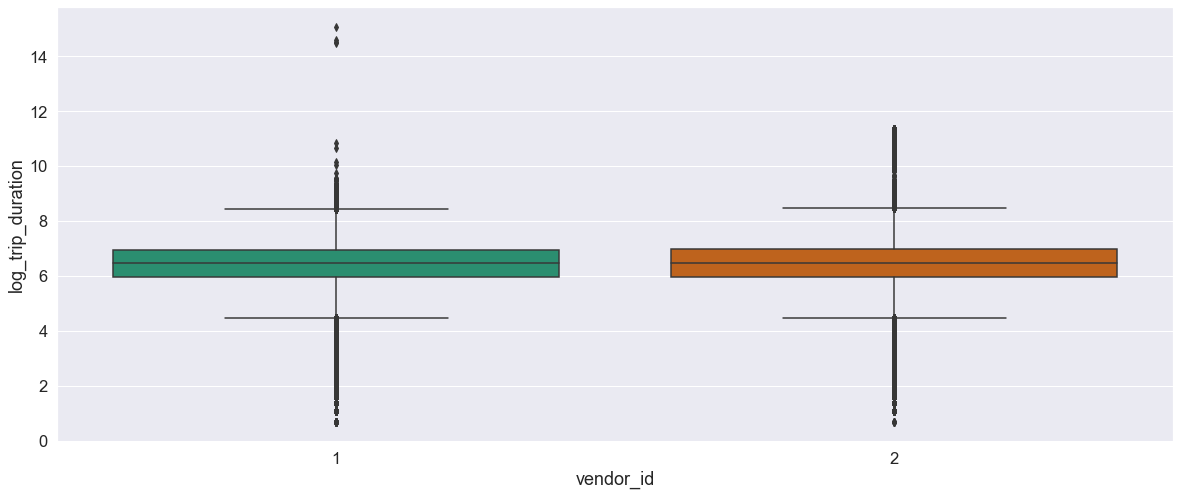

In [62]:
ax = sns.boxplot(x='vendor_id', y="log_trip_duration", data=train,  palette="Dark2")

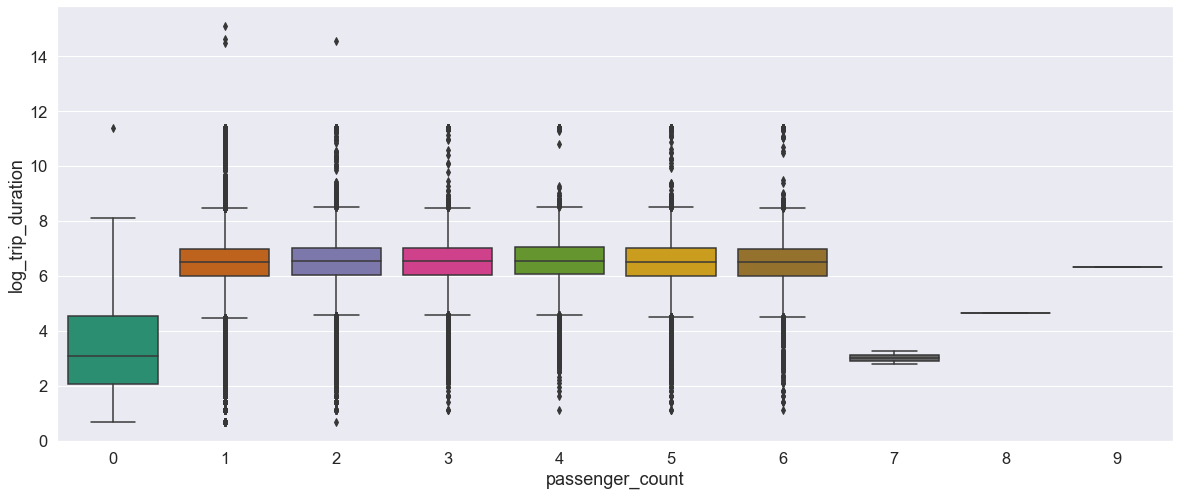

In [63]:
ax = sns.boxplot(x='passenger_count', y="log_trip_duration", data=train,  palette="Dark2",)

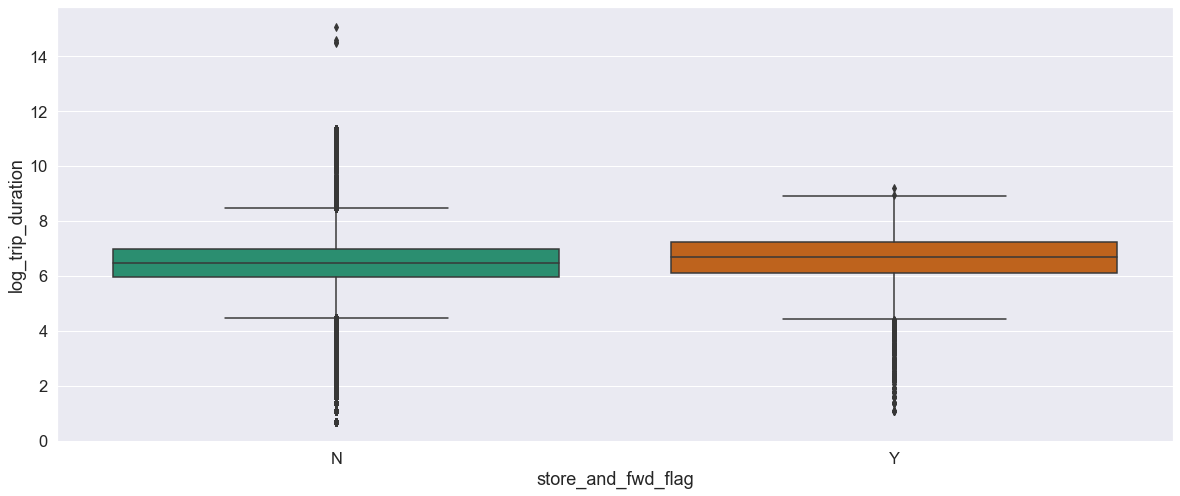

In [64]:
ax = sns.boxplot(x='store_and_fwd_flag', y="log_trip_duration", data=train,  palette="Dark2")

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [65]:
train['vendor_id'] = (
    np.where(
        train['vendor_id'] == 2,
        1, 0,
    )
)

train['store_and_fwd_flag'] = (
    np.where(
        train['store_and_fwd_flag'] == 'Y',
        1, 0,
    )
)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Кажется, что признаки vendor_id и store_and_fwd_flag не будут очень сильными для обучения, так как в этих признаках в целом одинаковое распределение логарифма длины поездки и для значения 0, и для значения 1, то есть каких то закономерностей эти признаки не отражают.

А вот признак passenger_count, может оказаться полезным для обучения, так как, хотя значения 1-6 показывают одинаковое распределение логарифма длительности поездки, остальные же значения признаков показывают различные распределения таргета, следовательно, эти признаки могут помочь модели найти закономерности в этих данных.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [66]:
y = train.log_trip_duration
X = train.drop(["log_trip_duration"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
categorical_features = ['day_of_week', 'month', 'hour', 'pickup', 'dropoff', 'vendor_id', 'store_and_fwd_flag', 'passenger_count']
numeric_features = ['day_of_year', 'log_haversine']
other = ['is_snowfall_period', 'is_airport_broke_period', 'is_trafic',
       'is_free', 'pickup_lag', 'dropoff_lag', 'pickup_ken', 'dropoff_ken']

column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features),
    ('other', 'passthrough', other)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


model = ridge_pipeline.fit(X_train, y_train)

y_pred_X_valid = model.predict(X_valid)
y_pred_X_train = model.predict(X_train)
y_pred_train = model.predict(train)

print("X_valid RMSE = %.4f" % mean_squared_error(y_valid, y_pred_X_valid, squared=False))
print("X_train RMSE = %.4f" % mean_squared_error(y_train, y_pred_X_train, squared=False))
print("train RMSE = %.4f" % mean_squared_error(y, y_pred_train, squared=False))

X_valid RMSE = 0.4744
X_train RMSE = 0.4751
train RMSE = 0.4749


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [68]:
drop_columns = ['vendor_id', 'store_and_fwd_flag', 'passenger_count']
train.drop(drop_columns, axis=1, inplace=True)

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

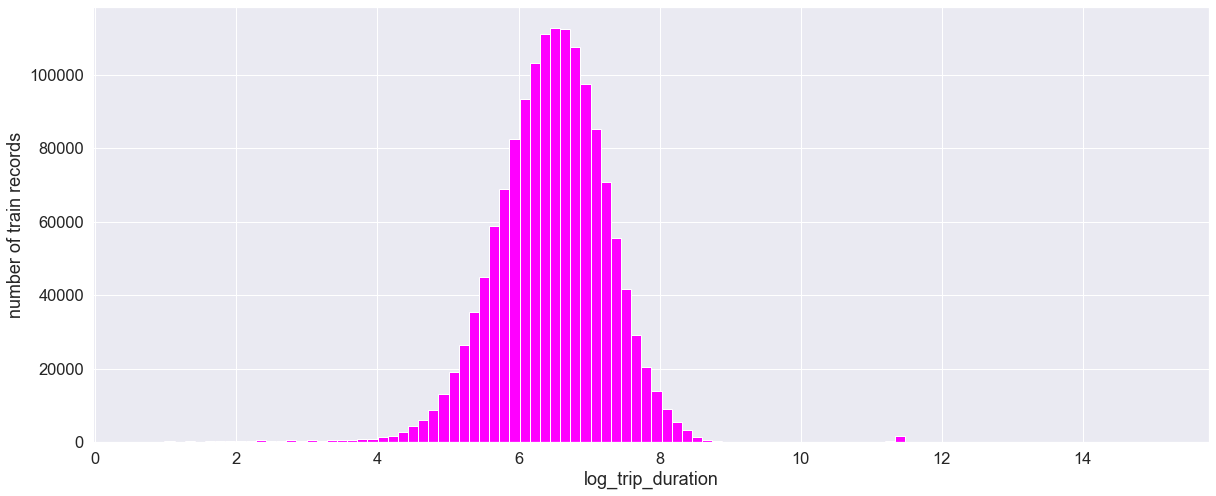

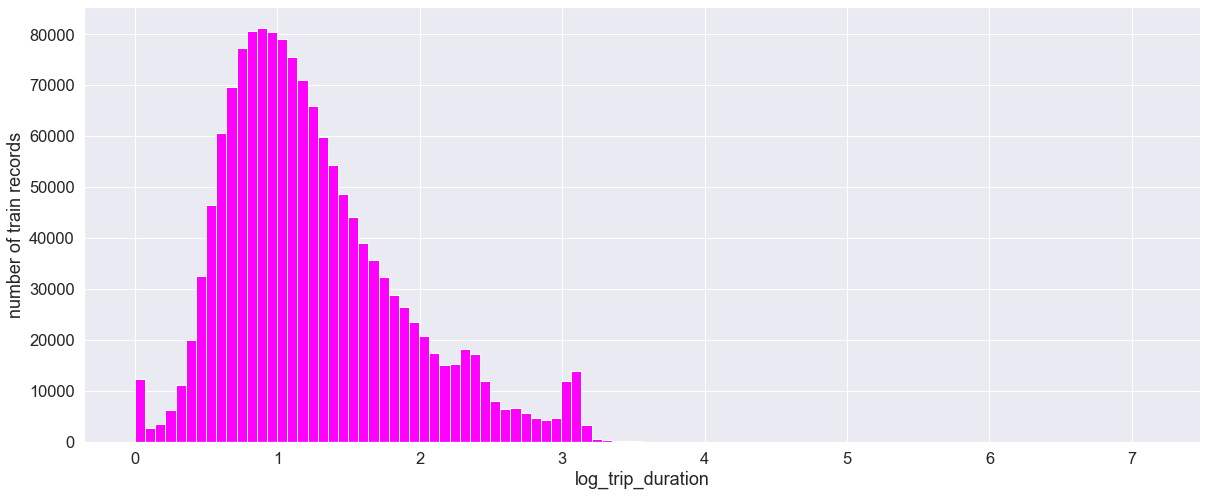

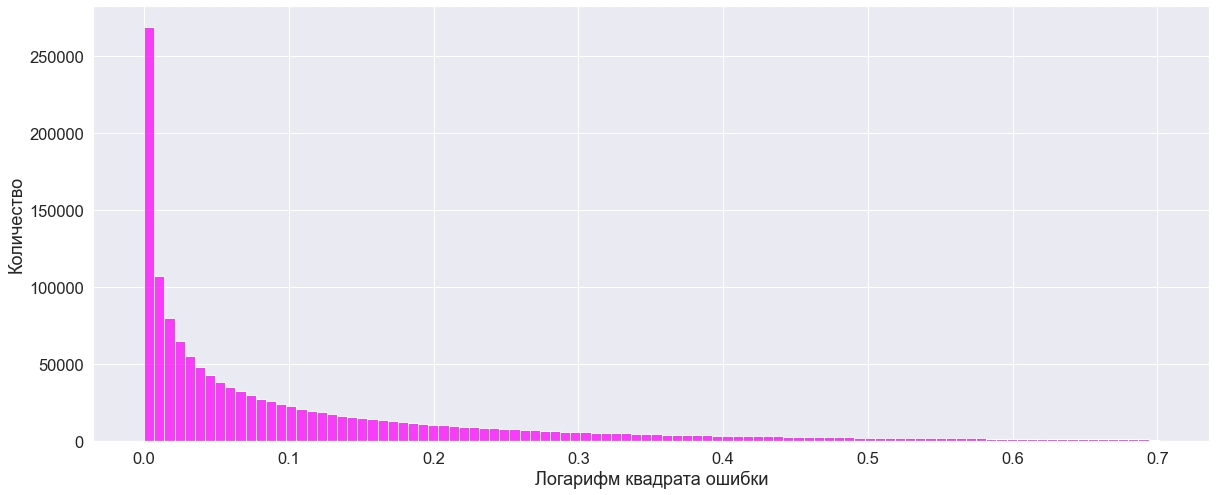

In [69]:
#время поездки
plt.hist(train['log_trip_duration'].values, bins=100, color='magenta')
plt.xlabel('log_trip_duration')
plt.ylabel('number of train records')
plt.show()

#пройденное расстояние
plt.hist(train['log_haversine'].values, bins=100, color='magenta')
plt.xlabel('log_trip_duration')
plt.ylabel('number of train records')
plt.show()

#остатки регресии
error = (y - y_pred_train)**2
sns.histplot(error[error < error.quantile(0.95)], bins=100, color='magenta')
plt.xlabel('Логарифм квадрата ошибки')
plt.ylabel('Количество')
plt.show()

In [70]:
train = train[(error < error.quantile(0.95))
              & (train['log_trip_duration'] > 4)
              & (train['log_haversine'] < 3.2)]

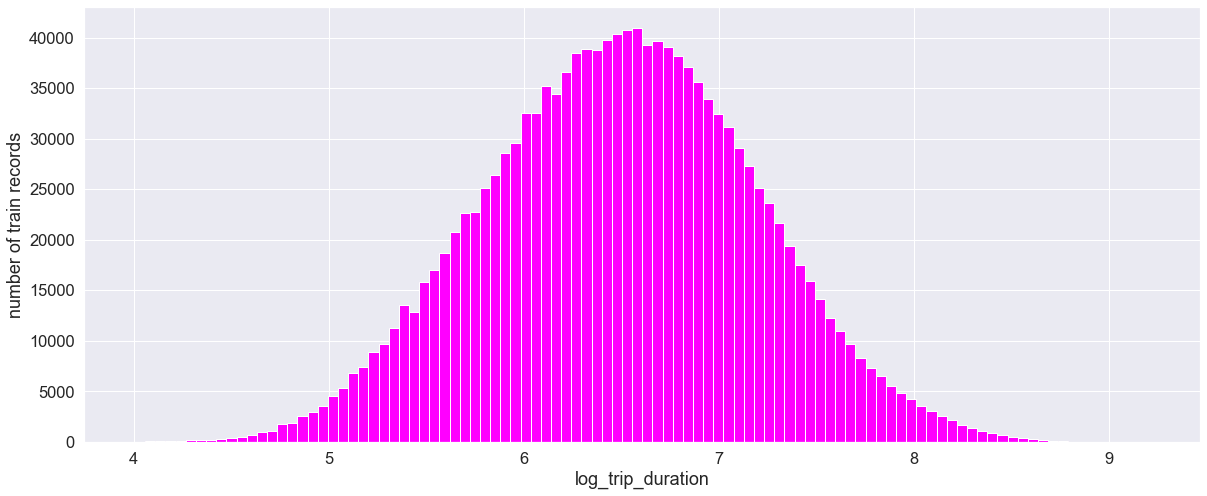

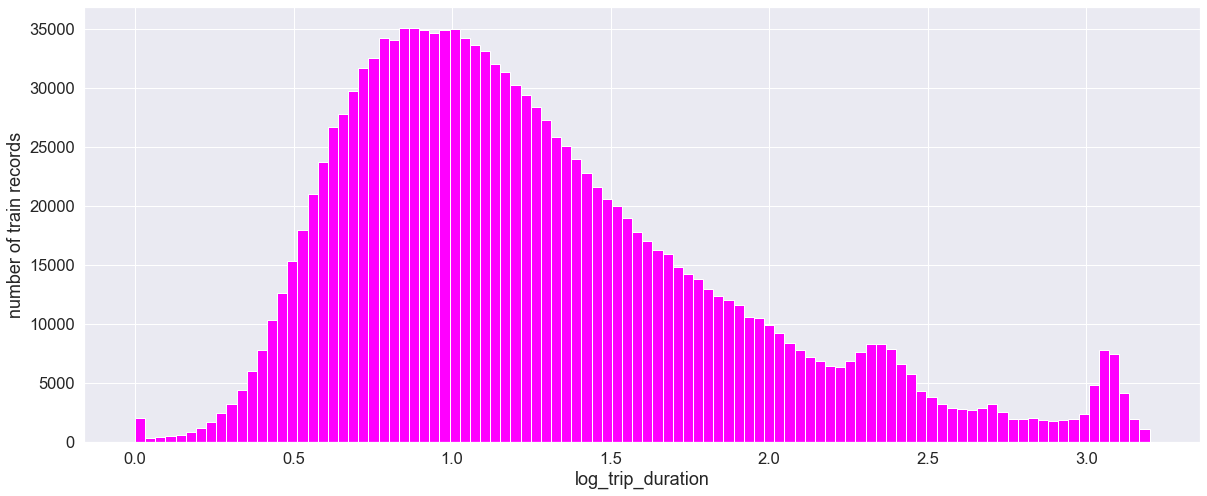

In [71]:
#время поездки
plt.hist(train['log_trip_duration'].values, bins=100, color='magenta')
plt.xlabel('log_trip_duration')
plt.ylabel('number of train records')
plt.show()

#пройденное расстояние
plt.hist(train['log_haversine'].values, bins=100, color='magenta')
plt.xlabel('log_trip_duration')
plt.ylabel('number of train records')
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

**`dropoff`**

In [72]:
counts_dropoff = train['dropoff'].value_counts(normalize=True)
counts_dropoff

0     0.208793
5     0.198577
4     0.182794
8     0.171901
9     0.151812
6     0.047963
7     0.021440
11    0.008815
12    0.005904
10    0.001599
1     0.000218
2     0.000134
3     0.000050
Name: dropoff, dtype: float64

**Найдем категории небольшого размера**

In [73]:
group_category = counts_dropoff[(counts_dropoff < counts_dropoff[9])].index
group_category

Int64Index([6, 7, 11, 12, 10, 1, 2, 3], dtype='int64')

**Создадим новую категорию из всех**

In [74]:
train.loc[train['dropoff'].isin(group_category), 'dropoff'] = 1

In [75]:
counts_dropoff = train['dropoff'].value_counts(normalize=True)
counts_dropoff

0    0.208793
5    0.198577
4    0.182794
8    0.171901
9    0.151812
1    0.086123
Name: dropoff, dtype: float64

**`pickup`**

In [76]:
counts_pickup = train['pickup'].value_counts(normalize=True)
counts_pickup

4     0.195864
0     0.190976
5     0.188342
8     0.182797
9     0.164492
6     0.042916
7     0.023305
12    0.006128
11    0.004760
10    0.000366
1     0.000027
2     0.000017
3     0.000007
Name: pickup, dtype: float64

**Найдем категории небольшого размера**

In [77]:
group_category = counts_pickup[(counts_pickup < counts_pickup[9])].index
group_category

Int64Index([6, 7, 12, 11, 10, 1, 2, 3], dtype='int64')

**Создадим новую категорию из всех**

In [78]:
train.loc[train['pickup'].isin(group_category), 'pickup'] = 1

In [79]:
counts_dropoff = train['pickup'].value_counts(normalize=True)
counts_dropoff

4    0.195864
0    0.190976
5    0.188342
8    0.182797
9    0.164492
1    0.077528
Name: pickup, dtype: float64

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [80]:
y = train.log_trip_duration
X = train.drop(["log_trip_duration"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [81]:
categorical_features = ['day_of_week', 'month', 'hour', 'pickup', 'dropoff']
numeric_features = ['day_of_year', 'log_haversine']
other = ['is_snowfall_period', 'is_airport_broke_period', 'is_trafic',
       'is_free', 'pickup_lag', 'dropoff_lag', 'pickup_ken', 'dropoff_ken']

column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features),
    ('other', 'passthrough', other)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


model = ridge_pipeline.fit(X_train, y_train)

y_pred_X_valid = model.predict(X_valid)
y_pred_X_train = model.predict(X_train)
y_pred_train = model.predict(train)

print("X_valid RMSE = %.4f" % mean_squared_error(y_valid, y_pred_X_valid, squared=False))
print("X_train RMSE = %.4f" % mean_squared_error(y_train, y_pred_X_train, squared=False))
print("train RMSE = %.4f" % mean_squared_error(y, y_pred_train, squared=False))

X_valid RMSE = 0.3356
X_train RMSE = 0.3366
train RMSE = 0.3363


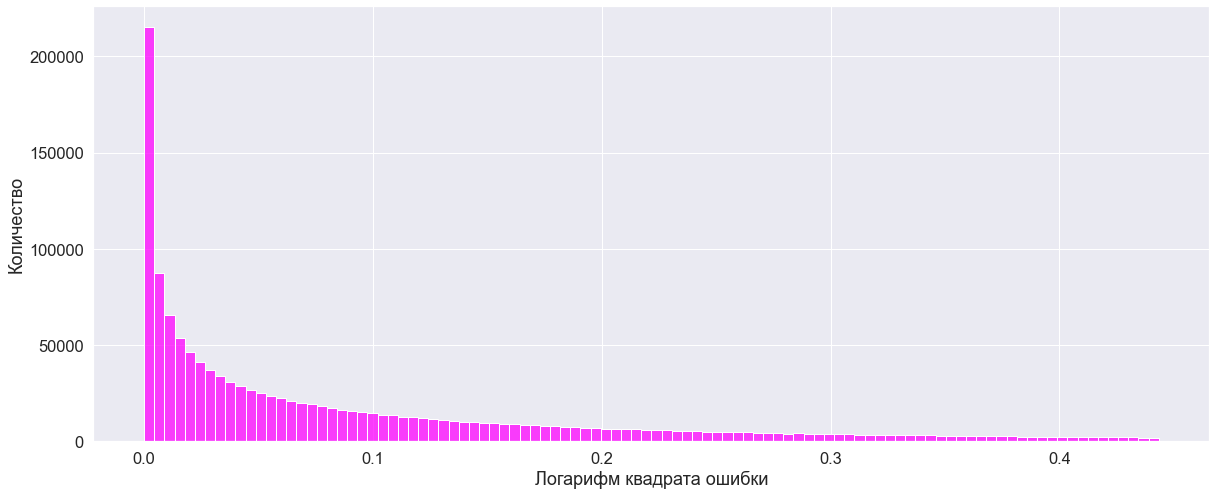

In [82]:
#остатки регресии
error = (y - y_pred_train)**2
sns.histplot(error[error < error.quantile(0.95)], bins=100, color='magenta')
plt.xlabel('Логарифм квадрата ошибки')
plt.ylabel('Количество')
plt.show()

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [83]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (968592, 22)
Size after OneHot: (968592, 59)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [84]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features),
    ('other', 'passthrough', other)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])


model = lasso_pipeline.fit(X_train, y_train)

y_pred_X_valid = model.predict(X_valid)
y_pred_X_train = model.predict(X_train)
y_pred_train = model.predict(train)

print("X_valid RMSE = %.4f" % mean_squared_error(y_valid, y_pred_X_valid, squared=False))
print("X_train RMSE = %.4f" % mean_squared_error(y_train, y_pred_X_train, squared=False))
print("train RMSE = %.4f" % mean_squared_error(y, y_pred_train, squared=False))

X_valid RMSE = 0.6923
X_train RMSE = 0.6914
train RMSE = 0.6917


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

**Подготовка данных**

In [85]:
y = train.log_trip_duration
X = train.drop(["log_trip_duration"], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features),
    ('other', 'passthrough', other)
])

X_train = column_transformer.fit_transform(X_train)
X_valid = column_transformer.transform(X_valid)

**`Lasso`**

In [89]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV

In [102]:
%%time
alphas = np.logspace(-4, -1, 10)
lasso_searcher = GridSearchCV(Lasso(), {"alpha": alphas}, cv=2, n_jobs=-1)
lasso_searcher.fit(X_train, y_train)

Wall time: 33.8 s


GridSearchCV(cv=2, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([0.0001    , 0.00021544, 0.00046416, 0.001     , 0.00215443,
       0.00464159, 0.01      , 0.02154435, 0.04641589, 0.1       ])})

In [125]:
lasso_searcher.best_params_

{'alpha': 0.0001}

In [127]:
y_pred_X_valid = lasso_searcher.predict(X_valid)
y_pred_X_train = lasso_searcher.predict(X_train)

print("X_valid RMSE = %.4f" % mean_squared_error(y_valid, y_pred_X_valid, squared=False))
print("X_train RMSE = %.4f" % mean_squared_error(y_train, y_pred_X_train, squared=False))

X_valid RMSE = 0.3356
X_train RMSE = 0.3365


**`Ridge`**

In [123]:
%%time
alphas = np.logspace(-4, -1, 10)
ridge_searcher = GridSearchCV(Ridge(), {"alpha": alphas}, cv=2, n_jobs=-1)
ridge_searcher.fit(X_train, y_train)

Wall time: 3.53 s


GridSearchCV(cv=2, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.0001    , 0.00021544, 0.00046416, 0.001     , 0.00215443,
       0.00464159, 0.01      , 0.02154435, 0.04641589, 0.1       ])})

In [126]:
ridge_searcher.best_params_

{'alpha': 0.01}

In [128]:
y_pred_X_valid = ridge_searcher.predict(X_valid)
y_pred_X_train = ridge_searcher.predict(X_train)

print("X_valid RMSE = %.4f" % mean_squared_error(y_valid, y_pred_X_valid, squared=False))
print("X_train RMSE = %.4f" % mean_squared_error(y_train, y_pred_X_train, squared=False))

X_valid RMSE = 0.3356
X_train RMSE = 0.3364


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [130]:
alphas = np.logspace(-4, -1, 10)
n_zeros = []
for alpha in alphas:
    reg = Lasso(alpha)
    reg.fit(X_train, y_train)
    n_zeros.append(np.sum(reg.coef_ == 0))

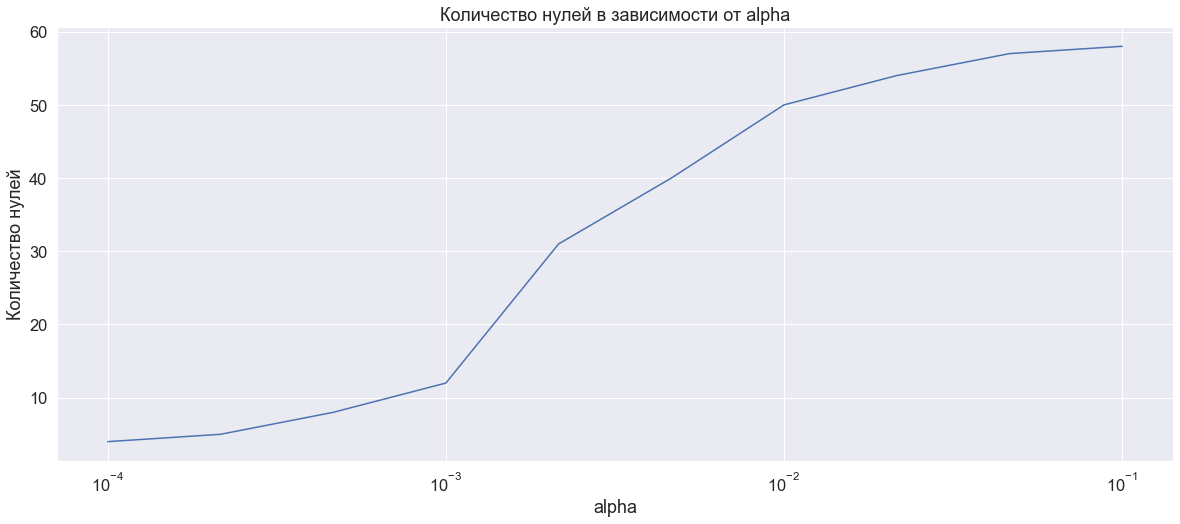

In [131]:
plt.plot(alphas, n_zeros)
plt.xscale('log')
plt.title('Количество нулей в зависимости от alpha')
plt.xlabel('alpha')
plt.ylabel('Количество нулей')
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.